In [2]:
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import numpy as np
import model_structure

path = "/Users/liushiwen/Desktop/大四下/hw2/test_data"
path = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train"
dir_list = os.listdir(path)

print(f"Files and directories in '{path}':")
# for item in dir_list:
#     print(item)


Files and directories in 'D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train':


0	0.7734375	0.4296875	0.21875	0.21875

(128, 128, 4)


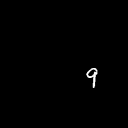

In [3]:
f = open(f"{path}/0000002.txt", "r")
print(f.read())
img = Image.open(f'{path}/0121744.png')
img = np.array(img)
print(img.shape)
img = Image.fromarray(img[:,:,2])
display(img)

In [4]:
img = Image.open(f'{path}/0121700.png')
r, g, b, trash = img.split()

r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)

# Check if all channels have the same array values
are_channels_same = np.array_equal(r_array, g_array) and np.array_equal(g_array, b_array)
are_channels_same

True

In [5]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = read_image(image_path)
        image = image[0:1].float()
        # print(image.shape)
        # image = image.reshape(1, 128, 128)
        
        txt_file = os.path.splitext(self.image_files[idx])[0] + ".txt"
        txt_path = os.path.join(self.data_folder, txt_file)
        with open(txt_path, "r") as f:
            first_line = f.readline().strip()
            class_label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_label

transform = transforms.Compose([transforms.Resize((28, 28)),
                                ])
data_folder = path
custom_dataset = CustomImageDataset(data_folder, transform)


In [10]:
from torchvision import datasets
import random
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset
def get_dataloaders(data_folder, transform, train_ratio, val_ratio, batch_size):
    # Create a single merged dataset
    train_dataset = CustomImageDataset(data_folder, transform)
    val_dataset = CustomImageDataset(data_folder, transform)
    test_dataset = CustomImageDataset(data_folder, transform)

    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)
    # file_names = [path for path, _ in train_dataset.imgs]
    # for ii in range(len(data_transforms.keys())-3):
    #     # print(ii)
    #     aug_dataset = datasets.ImageFolder(data_dir, transform = data_transforms[f'aug{ii}'])
    #     aug_sub = Subset(aug_dataset, train_idx)
    #     merge_dataset = ConcatDataset([merge_dataset,aug_sub])
    
    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [18]:
loaders = get_dataloaders(data_folder, transform, 0.3, 0.5, 256)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [71250, 15080, 23454, 92405, 94272]
--------- INDEX shuffled ---------

Total number of samples: 97396 datapoints
Number of train samples: 115 batches/ 29218 datapoints
Number of val samples: 134 batches/ 34089 datapoints
Number of test samples: 134 batches/ 34089 datapoints
Data Transform: Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
)



In [19]:
train_loader = loaders['train']
val_loader = loaders['val']
test_loader = loaders['test']

In [4]:
# print(custom_dataset[0][0])

In [20]:
# train_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(len(train_loader))

115


In [21]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [22]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [28]:
weight = "C:/Users/User/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth"
model = ResNet(BasicBlock, [2, 2, 2, 2])
model.load_state_dict(torch.load(weight))
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
import time
import torchvision.models as models
from torch import nn, optim
from tqdm import tqdm

model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iteration = 0
epochs = 1
start = time.time()
for epoch in range(epochs):

    for phase in ['train', 'val']:
        running_loss = 0.0
        correct_predictions = 0
        correct_top3_predictions = 0
        total_samples = 0
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        for images, labels in tqdm(loaders[phase]): # Iterate over data.
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)

            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train': # backward + optimize only if in training phase
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()

            # Convert outputs to predicted class by selecting the class with the highest score
            _, predicted = torch.max(outputs, 1)
            # Accumulate the number of correct predictions
            correct_predictions += (predicted == labels).sum().item()
            
            _, top3_preds = outputs.topk(3, 1, True, True)
            correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

            total_samples += labels.size(0)
            iteration += 1
            if iteration % 20 == 0:
                print(iteration)
            # break
        avg_loss = running_loss / len(train_loader)
        top1_accuracy = correct_predictions / total_samples * 100
        top3_accuracy = correct_top3_predictions / total_samples * 100
        print(f"Epoch [{epoch+1}/10], samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
end = time.time()
duration = end - start
print(f"Elapsed time: {duration} seconds")

model total parameters: 11,683,240


  0%|          | 0/115 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\GPU\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 18%|█▊        | 21/115 [00:03<00:12,  7.25it/s]

20


 36%|███▌      | 41/115 [00:05<00:09,  7.93it/s]

40


 53%|█████▎    | 61/115 [00:08<00:07,  6.82it/s]

60


 70%|███████   | 81/115 [00:11<00:04,  6.81it/s]

80


 88%|████████▊ | 101/115 [00:14<00:02,  6.99it/s]

100


100%|██████████| 115/115 [00:16<00:00,  7.17it/s]


Epoch [1/10], samples: 29218, Loss: 2.4741, Top-1 Accuracy: 19.15%, Top-3 Accuracy: 41.40%


  4%|▍         | 6/134 [00:00<00:12, 10.25it/s]

120


 19%|█▉        | 26/134 [00:03<00:12,  8.36it/s]

140


 34%|███▍      | 46/134 [00:05<00:12,  7.31it/s]

160


 49%|████▉     | 66/134 [00:08<00:09,  7.24it/s]

180


 64%|██████▍   | 86/134 [00:11<00:06,  7.90it/s]

200


 79%|███████▉  | 106/134 [00:14<00:03,  8.22it/s]

220


 94%|█████████▍| 126/134 [00:16<00:01,  7.90it/s]

240


100%|██████████| 134/134 [00:17<00:00,  7.58it/s]

Epoch [1/10], samples: 34089, Loss: 2.1747, Top-1 Accuracy: 31.53%, Top-3 Accuracy: 57.44%
Elapsed time: 33.73003911972046 seconds


In [ ]:
data_folder = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_test"

test_dataset = CustomImageDataset(data_folder, transform)

test_loader = DataLoader(custom_dataset, batch_size=128)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(len(test_loader))


761


In [21]:
# import torch
# import csv

# # Assuming model is your trained model and test_loader is your DataLoader for the test dataset
# model.eval()  # Set the model to evaluation mode

# # Path to save the CSV file
# output_csv_path = 'test_predictions.csv'

# with torch.no_grad():  # No need to track gradients for validation
#     with open(output_csv_path, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['filename', 'class'])  # Write the header row

#         for images, labels, filenames in test_loader:  # Assuming filenames are provided
#             images = images.cuda()
#             outputs = model(images)

#             _, predicted = torch.max(outputs, 1)
#             predicted_classes = [test_loader.dataset.classes[pred] for pred in predicted]  # Convert to class names if applicable

#             for filename, pred_class in zip(filenames, predicted_classes):
#                 writer.writerow([filename, pred_class])

# print(f"Results saved to {output_csv_path}")


AttributeError: 'CustomImageDataset' object has no attribute 'classes'

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 64 * 64)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset (you can replace this with your own dataset)
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root="D:\Casper\OTHER\Data\cifar", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize the model
model = SimpleCNN()
model = model.cuda()
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (you can adjust the number of epochs)
for epoch in range(10):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
        
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Convert outputs to predicted class by selecting the class with the highest score
        _, predicted = torch.max(outputs, 1)
        # Accumulate the number of correct predictions
        correct_predictions += (predicted == labels).sum().item()
        # Accumulate the total number of samples seen
        total_samples += labels.size(0)

        # Optional: break here if you want to test with just the first batch
        # break

    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100
        # break
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Files already downloaded and verified
Epoch [1/10], Loss: 1.7137, Accuracy: 37.24%
Epoch [2/10], Loss: 1.5531, Accuracy: 43.10%
Epoch [3/10], Loss: 1.5096, Accuracy: 44.43%
Epoch [4/10], Loss: 1.4768, Accuracy: 45.74%


KeyboardInterrupt: 

In [ ]:

# Save the trained model
torch.save(model.state_dict(), "simple_cnn_model.pth")
